DDPM
====


 * Forward process: $q(x_t|x_{t-1})$
 * Reverse process: $p_\theta(x_{t-1}|x_{t})$


$$q(x_t|x_0)=\mathcal{N}\left(x_t; \sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)\mathbb{I}\right)$$

$$q(x_t|x_{t-1})=\mathcal{N}\left(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t\mathbb{I}\right)$$


 * Forward equation:
$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{(1-\bar{\alpha}_t)}\epsilon$$

$\alpha_t = 1-\beta_i$


$\bar{\alpha}_t = \prod_{i=1}^t \alpha_t$

 * Linear noise scheduler:
   * $\beta_1=0.0001$
   * $\beta_T=0.02$


* Reverse: $x_T \rightarrow x_{T-1}$

$$p_\theta \left(x_{t-1}|x_t\right)$$

$$\mu_\theta = \frac{x_t}{\sqrt{\alpha_t}} - \frac{(1-\alpha_t)\sqrt{1-\bar{\alpha}_t}}{(1-\bar{\alpha}_t)\sqrt{\bar{\alpha}_t}}\epsilon_\theta$$

$$\Sigma_\theta(t) = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t} \mathbb{I}$$

$\mu_\theta + \sigma_t z \rightarrow x_{T-1}$

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

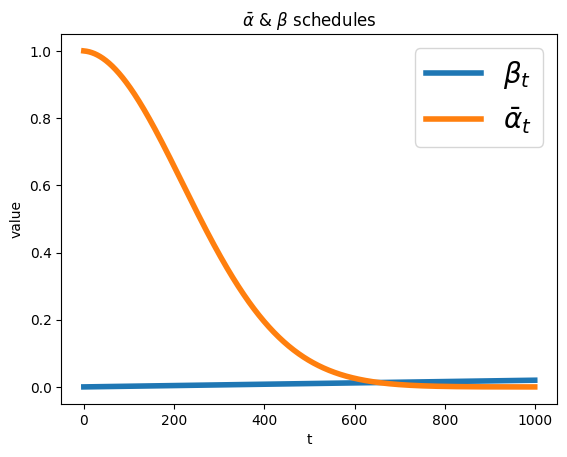

In [2]:
# beta schedules
def beta_schedule(t, beta0, beta1, T):
    return beta0 + (beta1 - beta0) * t / T

# alpha_t = 1 - beta_t
# alpha_bar_t = cumulative product of alpha_t
def alpha_bar(beta0, beta1, T):
    alpha_bar = []
    for t in range(T):
        alpha_t = 1 - beta_schedule(t, beta0, beta1, T)
        if t == 0:
            alpha_bar_t = alpha_t
        else:
            alpha_bar_t = alpha_bar_t * alpha_t
        alpha_bar.append(alpha_bar_t)
    return alpha_bar

# plot beta schedules: 0.0001 -> 0.02, T=1000
T = 1000
t = np.arange(T)
beta0 = 0.0001
beta1 = 0.02
plt.plot(t, beta_schedule(t, beta0, beta1, T), lw=4, label=r'$\beta_t$')
plt.plot(t, alpha_bar(beta0, beta1, T), lw=4, label=r'$\bar{\alpha}_t$')
plt.xlabel('t')
plt.ylabel('value')
plt.title(r'$\bar{\alpha}$ & $\beta$ schedules')
plt.legend(fontsize=20)
plt.show()

### Naive forward implementation

$$x_{t} = \sqrt{1-\beta_t} x_{t-1} + \sqrt{\beta_t} \mathcal{N}(0, \mathbb{I})$$

0it [00:00, ?it/s]
100%|██████████| 999/999 [00:48<00:00, 20.77it/s]


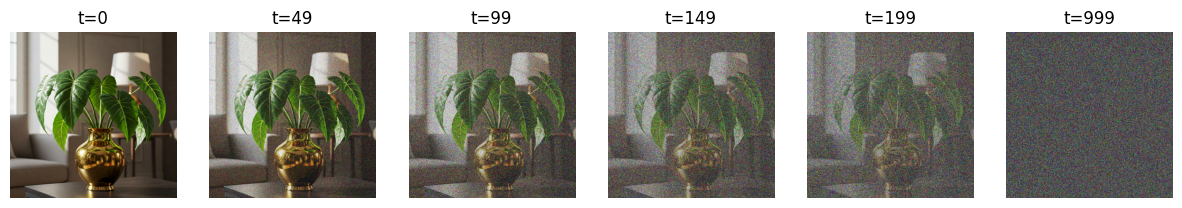

In [38]:
from tqdm import tqdm

def naive_forward(image, timestep, beta_t):
    # forward pass
    x = image
    for t in tqdm(range(timestep)):
        eps = np.random.randn(*x.shape)
        x = np.sqrt(1 - beta_t) * x + np.sqrt(beta_t) * eps
    return x


# Visualization of the forward process
def visualize_forward_process(noised_images):
    """
    Visualize the progression of the forward diffusion process.
    """
    n = len(noised_images)
    fig, axes = plt.subplots(1, n, figsize=(15, 10))
    for i, (t, img) in enumerate(noised_images):
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f"t={t}")
        axes[i].axis("off")
    plt.show()


beta_min, beta_max = 0.0001, 0.02
total_steps = 1000
betas = np.linspace(beta_min, beta_max, total_steps)  # Linear schedule

image = Image.open('images/plant.jpg').convert('RGB')
image = np.array(image).astype(np.float32) / 255
image = resize(image, (1024, 1024), anti_aliasing=True)
noised_images = []
for i, timestep in enumerate([0, 49, 99, 149, 199, 999]):
    noised_image = naive_forward(
        image.copy(), timestep, beta_t=betas[timestep]
    )
    noised_images.append((timestep, noised_image))

visualize_forward_process(noised_images)

### Directly jump to step $t$


$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{(1-\bar{\alpha}_t)}\epsilon$$

In [ ]:
# Define the forward diffusion process
# directly jump to the timestep you want to see
def forward_diffusion(image, alpha_bar_t):
    """
    Add noise to the image over timesteps
    following a diffusion schedule.
    """
    noise = np.random.normal(0, 1, image.shape)
    noised_image = np.sqrt(alpha_bar_t) * image + np.sqrt(1 - alpha_bar_t) * noise
    return noised_image


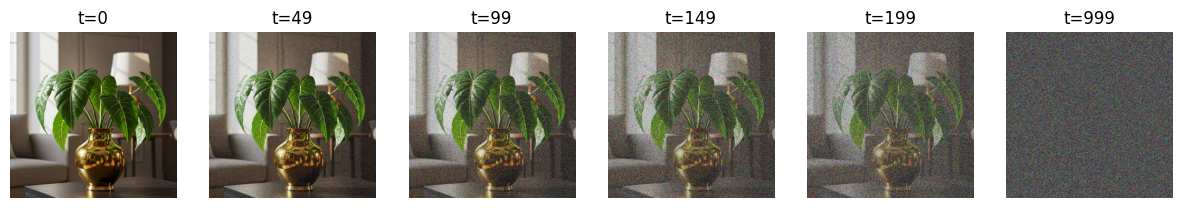

In [39]:
image = Image.open("images/plant.jpg")
image = np.asarray(image).astype(np.float32) / 255
image = resize(image, (1024, 1024), anti_aliasing=True)

total_steps = 1000  # Number of diffusion steps
beta_min, beta_max = 0.0001, 0.02
betas = np.linspace(beta_min, beta_max, total_steps)  # Linear schedule
alphas = 1 - betas
alphas_cumprod = np.cumprod(alphas)



noised_images = [(0, image.copy())]
for t in [49, 99, 149, 199, 999]:
    noised_image = forward_diffusion(
        image.copy(), alphas_cumprod[t]
    )
    noised_images.append((t, noised_image))

# Visualize forward process
visualize_forward_process(noised_images)

<img src="images/training.png" alt="training" width="400"/>

In [ ]:
def reverse_diffusion(noised_images, alphas_cumprod):
    """
    Reverse the forward diffusion process.
    """
    timesteps = len(noised_images)
    alphas_cumprod_inv = np.flip(alphas_cumprod)
    
    images = []
    for t in range(timesteps):
        image = noised_images[t]
        for t_prime in range(t):
            noise = np.random.normal(0, 1, image.shape)
            image = np.sqrt(alphas_cumprod_inv[t_prime]) * image + np.sqrt(1 - alphas_cumprod_inv[t_prime]) * noise
        images.append(image)
    
    return images